In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnninterpreter import *

In [3]:
import torch

# Cyclicity

In [4]:
dataset = CyclicityDataset(seed=12345)

data: Data(x=[96, 1], edge_index=[2, 192], edge_attr=[192, 2], y=[1], G=Graph with 96 nodes and 96 edges)
class: red_cyclic


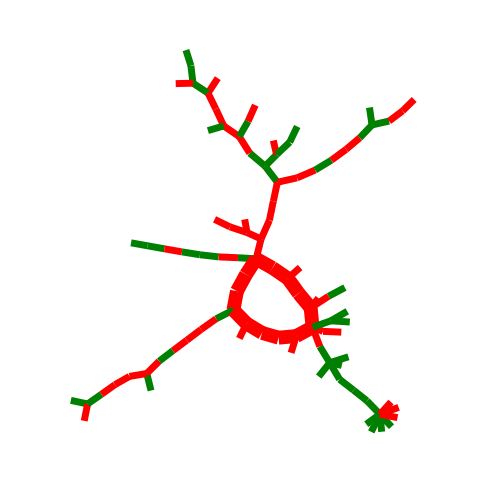

In [5]:
dataset.show(7)

In [6]:
model = NNConvClassifier(node_features=len(dataset.NODE_CLS),
                         edge_features=len(dataset.EDGE_CLS),
                         num_classes=len(dataset.GRAPH_CLS),
                         hidden_channels=32)

In [7]:
model.load_state_dict(torch.load('ckpts/cyclicity.pt'))

<All keys matched successfully>

In [8]:
dataset.evaluate_model(model)

/opt/homebrew/Caskroom/mambaforge/base/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'red_cyclic': 0.9783830046653748,
 'green_cyclic': 0.9642987251281738,
 'acyclic': 0.9724578261375427}

In [9]:
mean_embeds = dataset.mean_embeddings(model)

In [10]:
trainer = {}
sampler = {}

# Red Cyclic

In [17]:
cls_idx = 0
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_edge_cls=len(dataset.EDGE_CLS),
        temperature=0.15,
        learn_node_feat=False,
        learn_edge_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=2),
        dict(key="omega", criterion=NormPenalty(order=2), weight=2),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)

In [18]:
trainer[0].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=14 m=15
logits=[35.9268913269043, -14.380946159362793, 7.633147239685059]
probs=[1.0, 1.4176968950879997e-22, 5.154463553029565e-13]


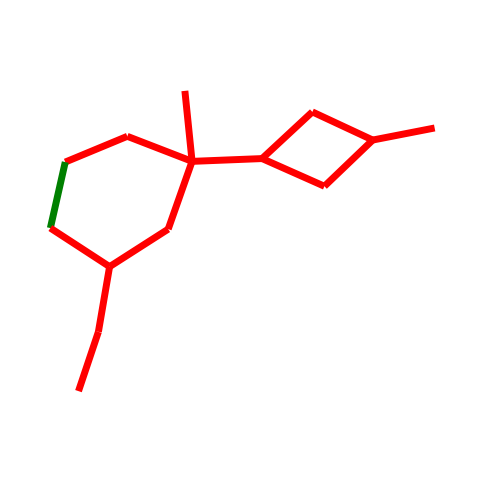

In [19]:
trainer[0].evaluate(threshold=0.5, show=True)

# Green Cyclic

In [20]:
cls_idx = 1
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_edge_cls=len(dataset.EDGE_CLS),
        temperature=0.15,
        learn_node_feat=False,
        learn_edge_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=2),
        dict(key="omega", criterion=NormPenalty(order=2), weight=2),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)

In [21]:
trainer[1].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=4 m=4
logits=[5.780906677246094, 32.00634002685547, 10.893763542175293]
probs=[4.077922895195929e-12, 1.0, 6.775244254519919e-10]


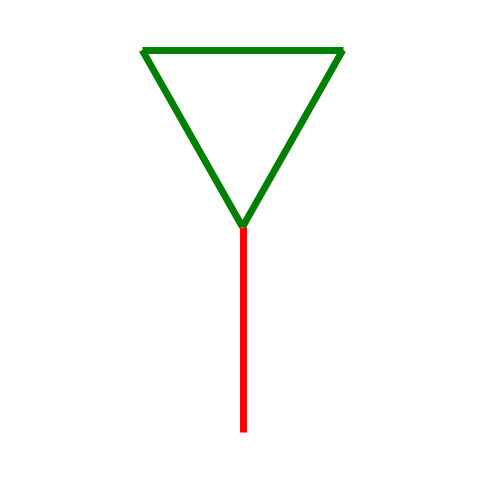

In [22]:
trainer[1].evaluate(threshold=0.5, show=True)

# Acyclic

In [23]:
cls_idx = 2
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_edge_cls=len(dataset.EDGE_CLS),
        temperature=0.15,
        learn_node_feat=False,
        learn_edge_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=2),
        dict(key="omega", criterion=NormPenalty(order=2), weight=2),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)

In [24]:
trainer[2].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=16 m=14
logits=[-9.640027046203613, -17.876792907714844, -0.3369973301887512]
probs=[9.113932173931971e-05, 2.4128162579017953e-08, 0.9999088048934937]


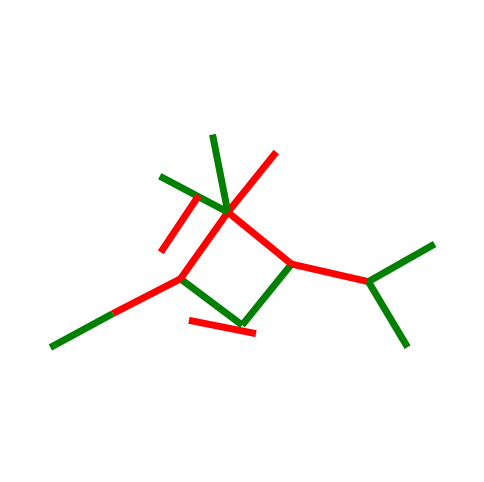

In [25]:
trainer[2].evaluate(threshold=0.5, show=True)